In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import yaml
import pprint
import pandas as pd
from pandas.io.json import json_normalize

sys.path.insert(1, '../BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

   
def plotHeadGroup(readme, data, lipid):
    fig= plt.figure(figsize=(10,7))
    #print(data)
    for doi in data:
        RealData = data[doi]
        for key2, value in RealData.items():
            #print(key2,value)                    
            #plt.gca().invert_yaxis()
            #plt.ylim([0,1])               
            if lipid == 'POPG' and 'M_G3C6_M' in key2:
                l = None
                plt.plot(0,value[5],"s", color='red', label = l,marker=".", markersize=10)  #color=colors[i],
            if 'M_G3N6' in value: 
                l = None
                plt.plot(0,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G3C5_M' in key2:
                l = None
                plt.plot(1,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G3C4_M' in key2:
                l = None
                plt.plot(2,value[5],"s",color='red', label = l,marker=".", markersize=10)
            if 'M_G3_M' in key2:
                l = None
                plt.plot(3,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G2_M' in key2:
                l = lipid + " " + readme.get('FF')
                plt.plot(4,value[5],"s",color='red',label = l,marker=".", markersize=10)
            if 'M_G1_M' in key2:
                l = None
                plt.plot(5,value[5],"s",color='red',label = l,marker=".", markersize=10)
            plt.legend( loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
            plt.ylabel('Quality', fontsize=20)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            # plt.ylim(0,-1050)
            plt.title(readme['SYSTEM'] + " DOI: " + doi, fontsize=24)

    return fig



def plotTails(readme,data,name_tail):
    for doi in data:
        RealData = data[doi]
        keys_list = list(RealData.keys())
        tail = []
        if name_tail == 'palmitoyl':
            tail = [x for x in keys_list if 'M_G1C' in x]
        elif name_tail == 'oleoyl':
            tail = [x for x in keys_list if 'M_G2C' in x]
        
        if tail:
            fig1= plt.figure(figsize=(10,7))
            previous_key = ""
            for index, key in enumerate(tail):
                #plt.gca().invert_yaxis()
                #plt.ylim([0,1])
                if key[0:-3] == previous_key[0:-3]:
                    plt.plot(index-1,RealData[key][5],"s",color='red',marker=".", markersize=10)
                else:
                    plt.plot(index,RealData[key][5],"s",color='red',marker=".", markersize=10)
                if key[0:-3] != previous_key[0:-3]:
                    previous_key = key
            plt.title(readme['SYSTEM'] + " " + readme['FF'] + " " + name_tail + " DOI: " + doi, fontsize=24)
            # plt.legend(loc='upper left',ncol=2, fontsize=15, bbox_to_anchor=(0.5, 1.01))
            # plt.ylabel('Quality', fontsize=20)
            return fig1
        else:
            print('No quality data for acyl tails')
            return ""

In [2]:
path = '../../Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

# Making very rough plots on quality

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails
No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No quality data for acyl tails
No quality data for acyl tails


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

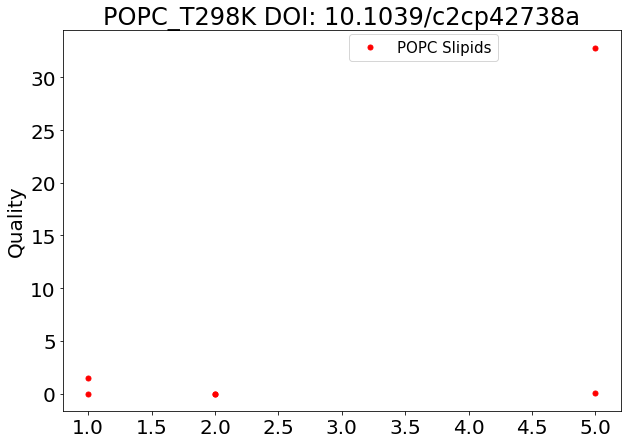

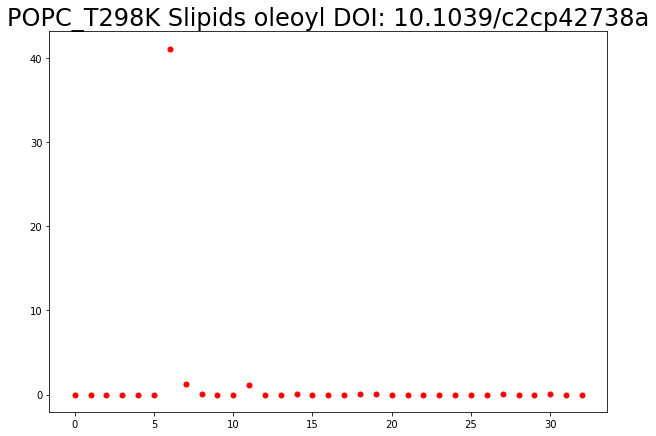

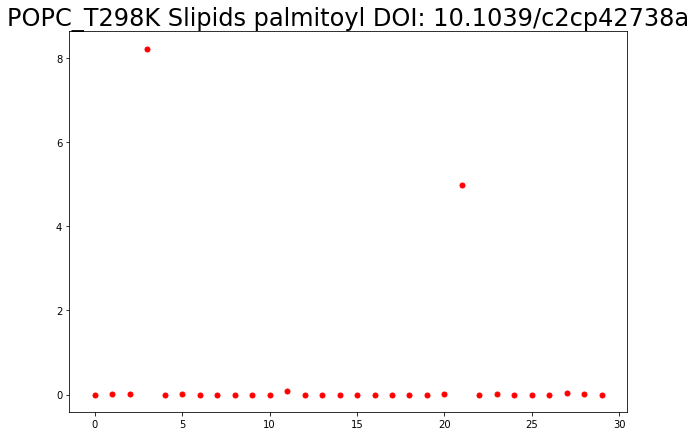

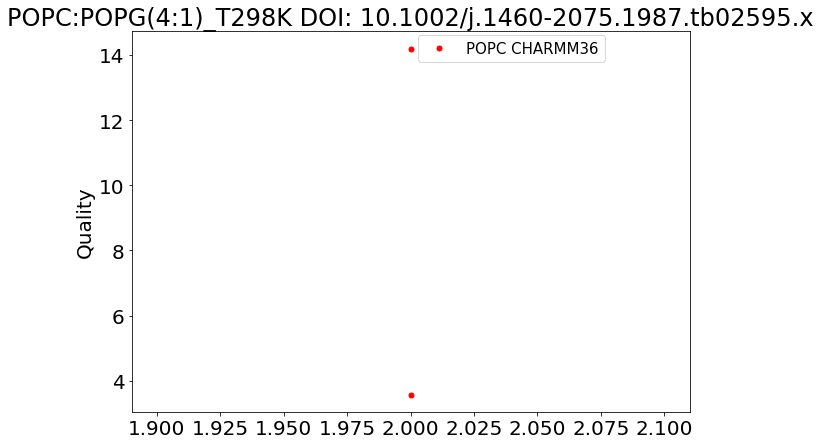

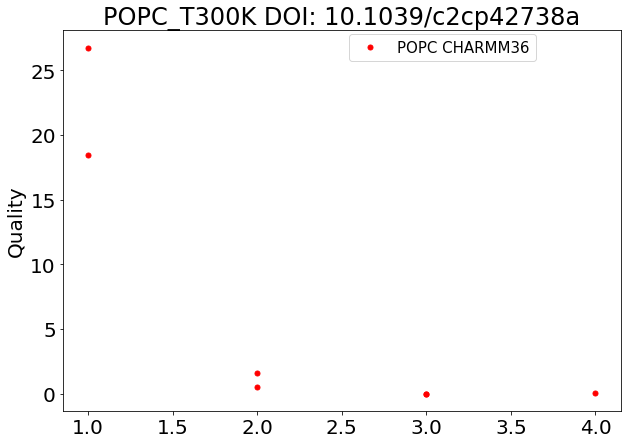

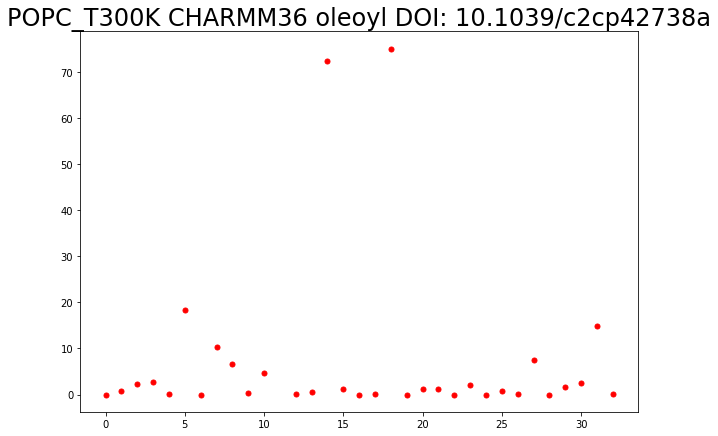

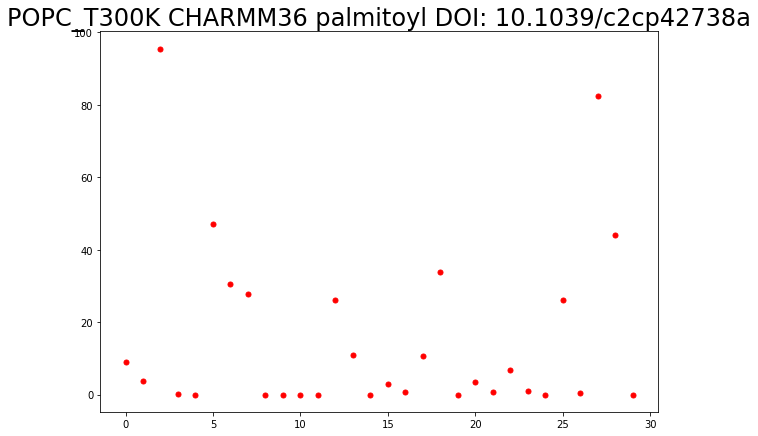

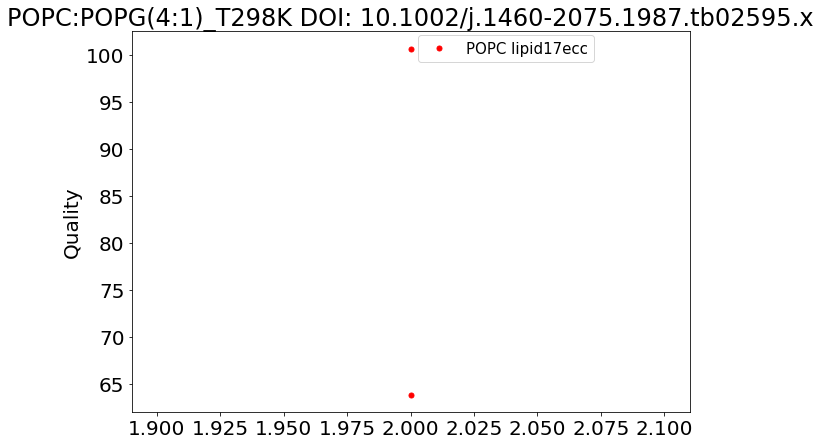

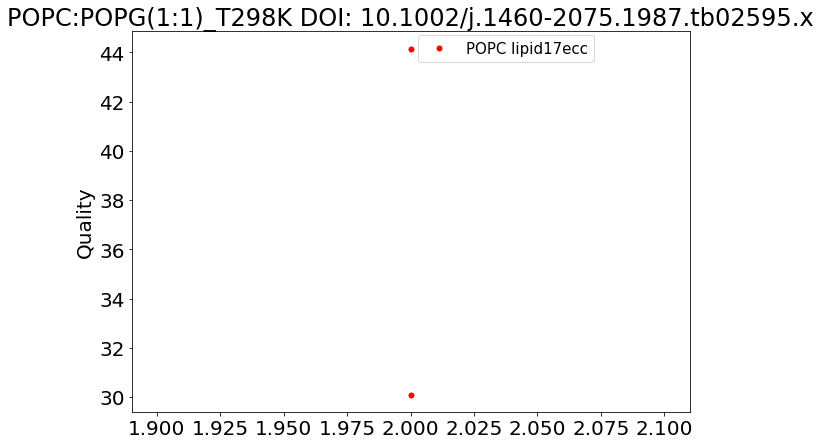

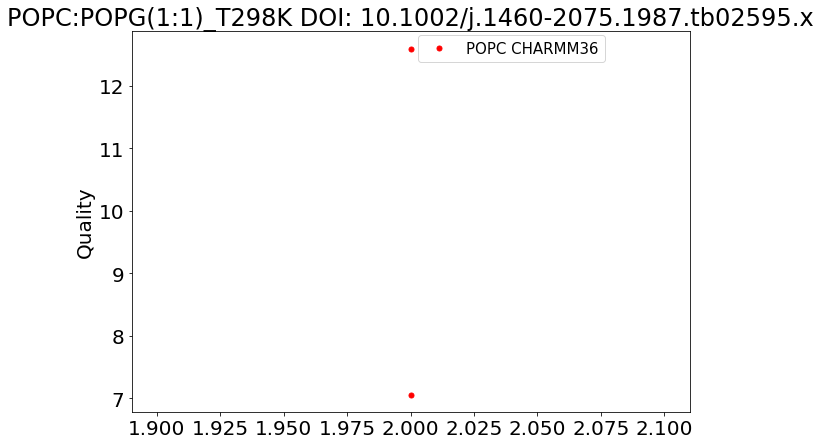

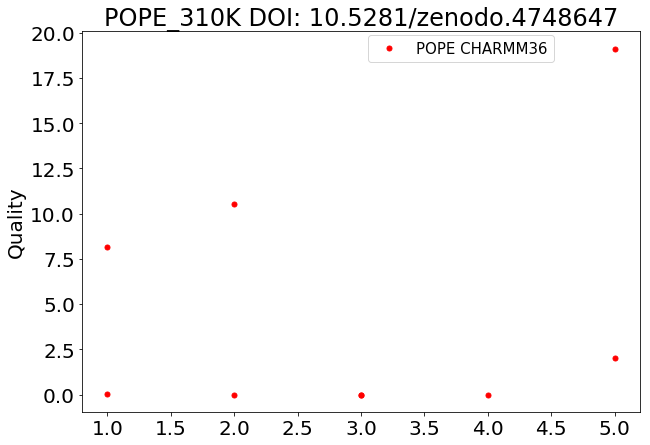

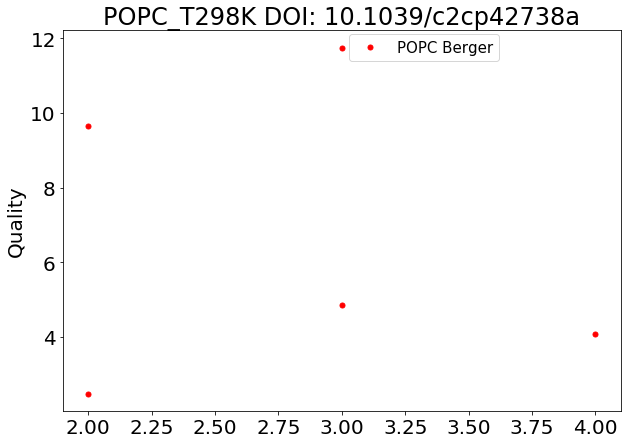

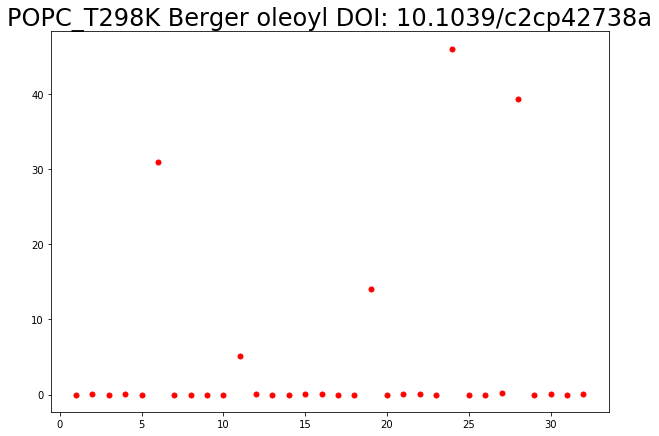

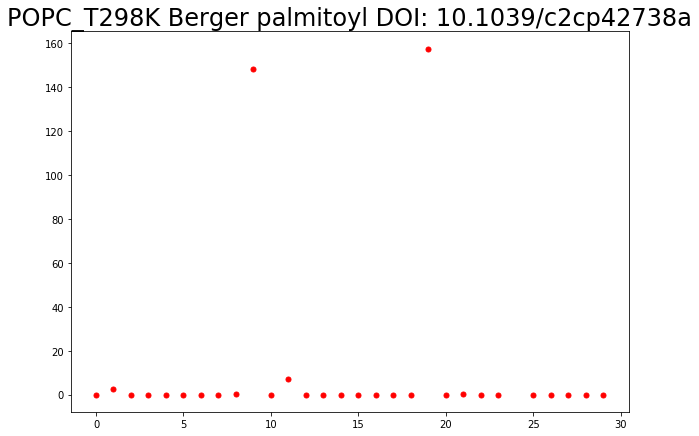

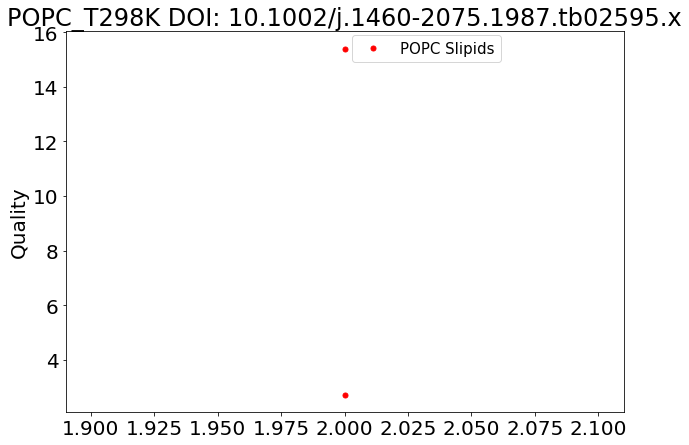

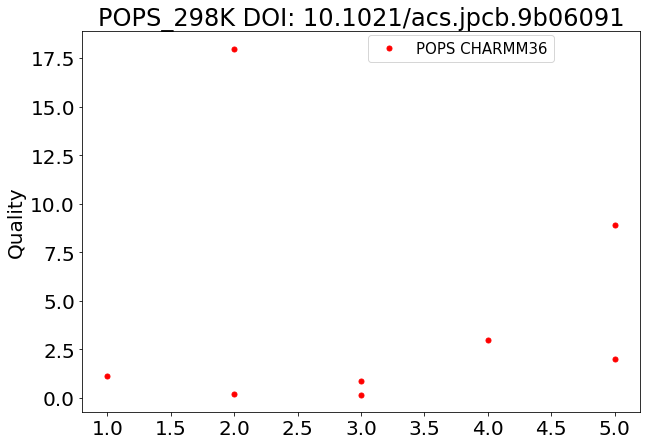

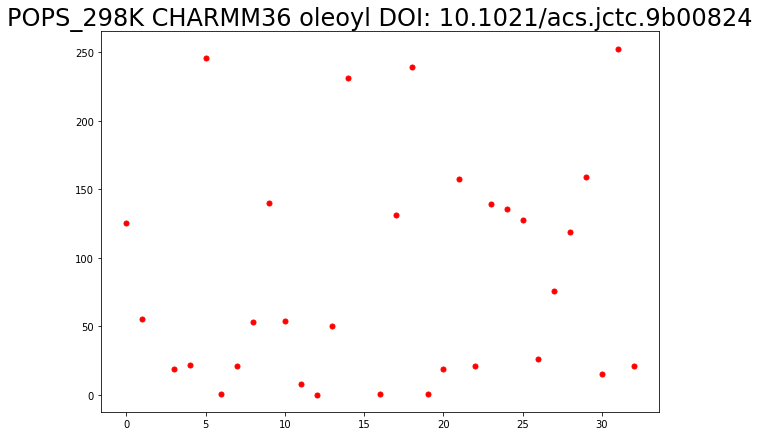

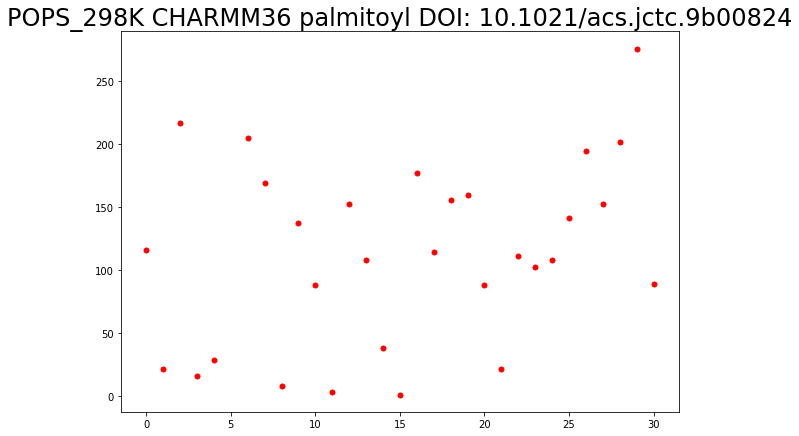

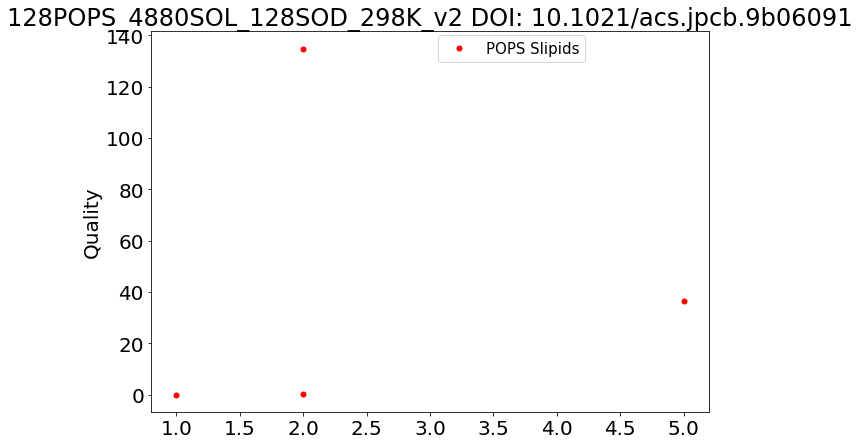

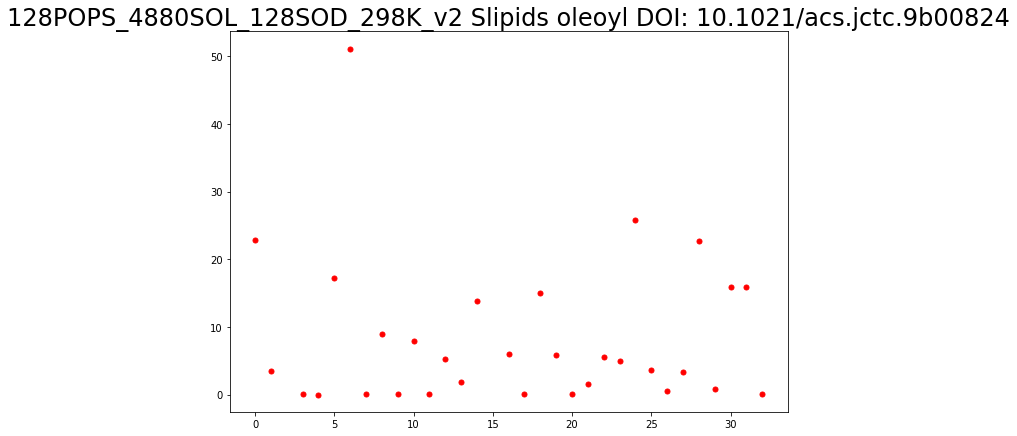

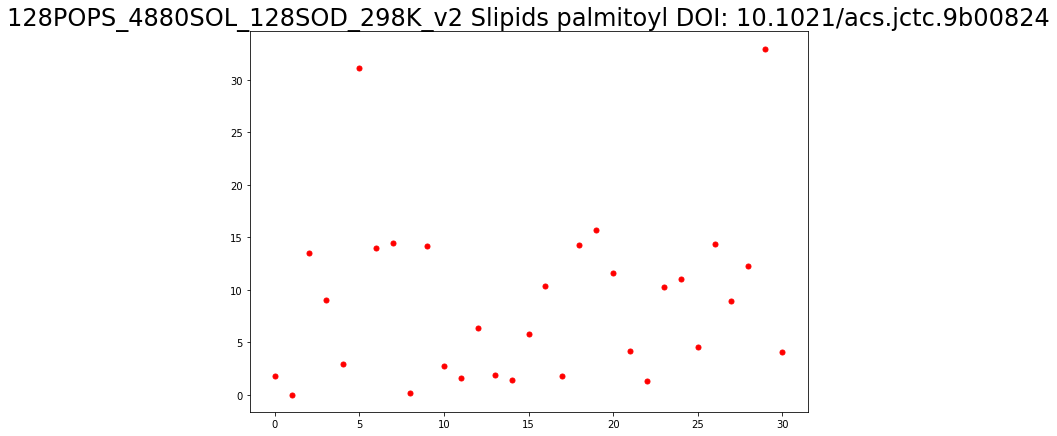

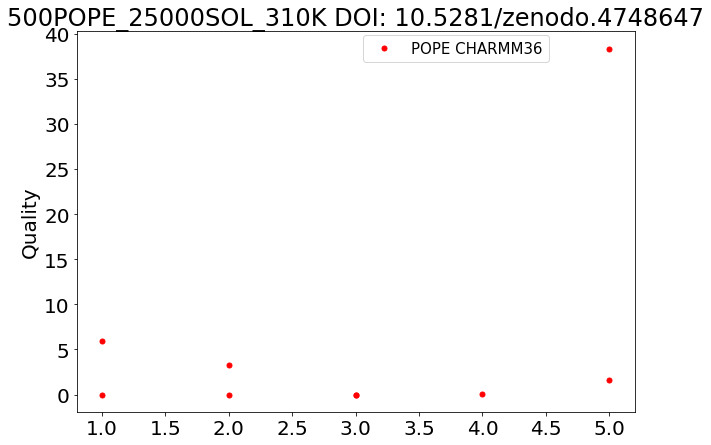

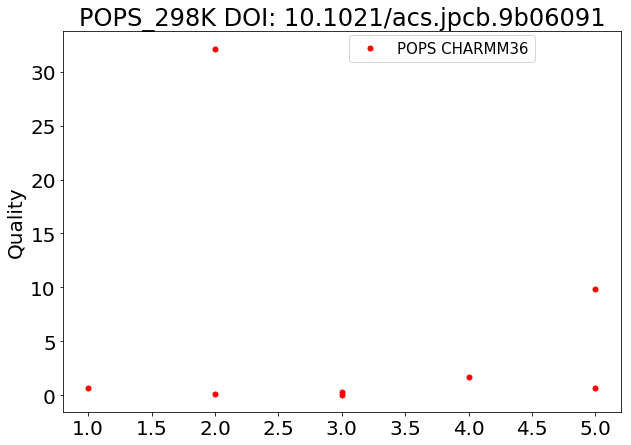

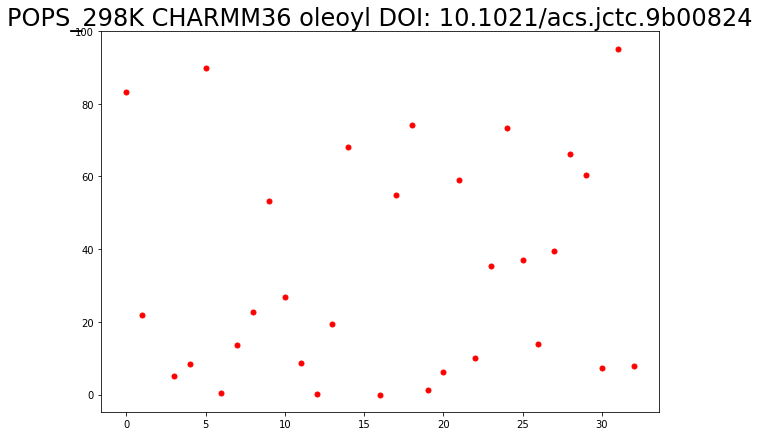

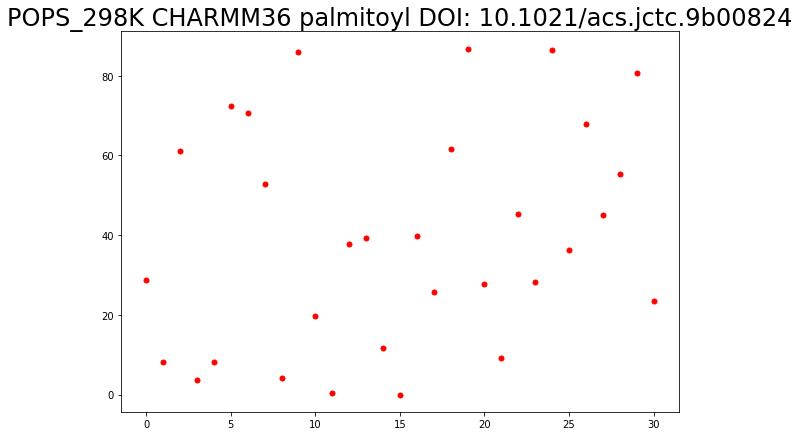

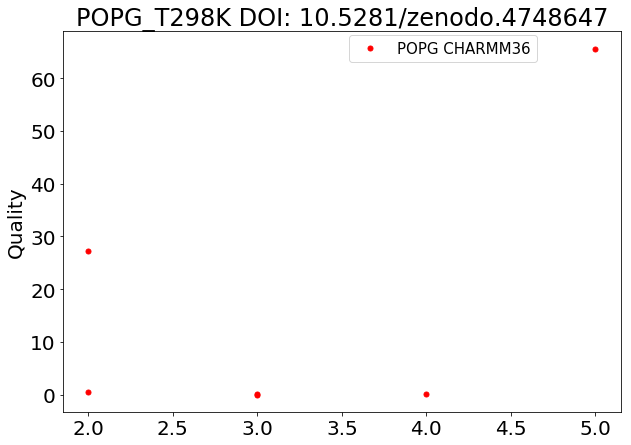

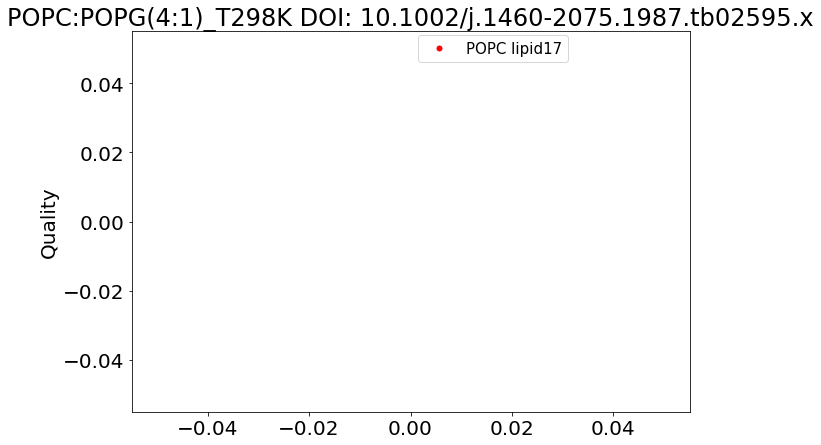

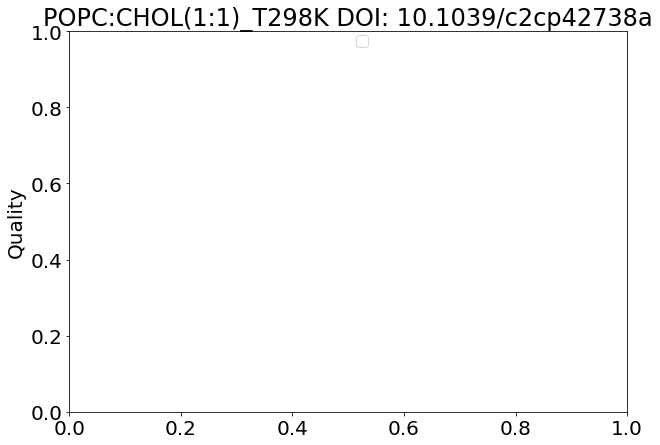

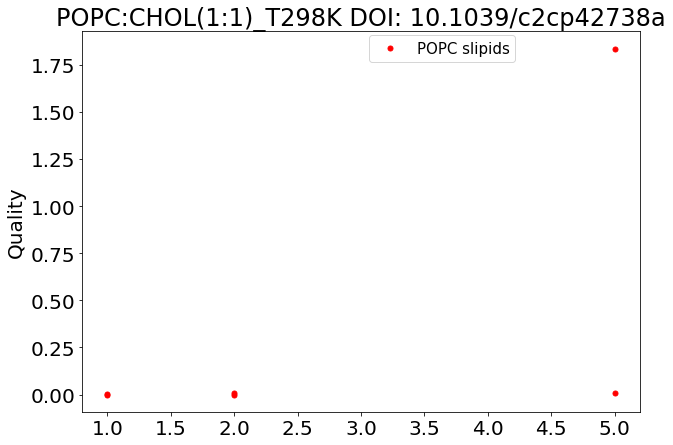

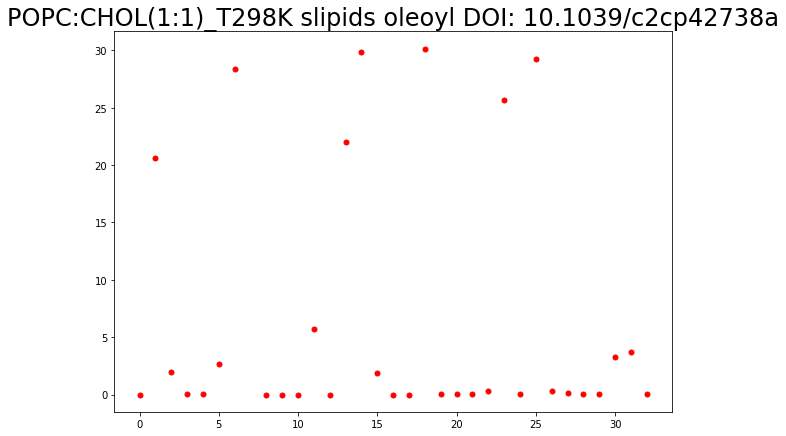

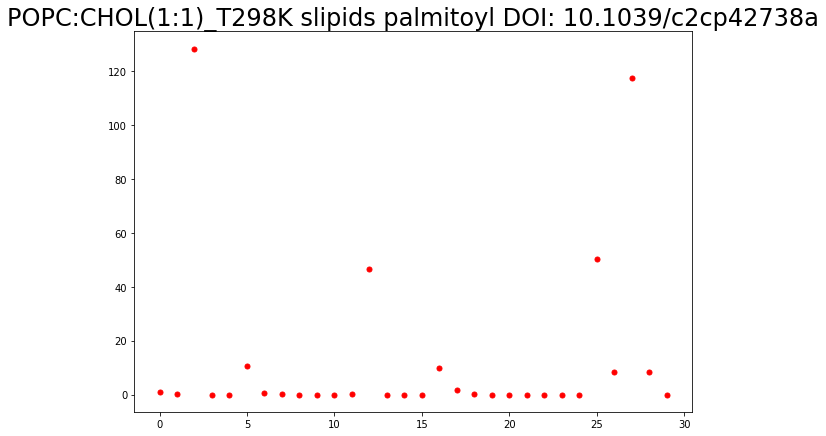

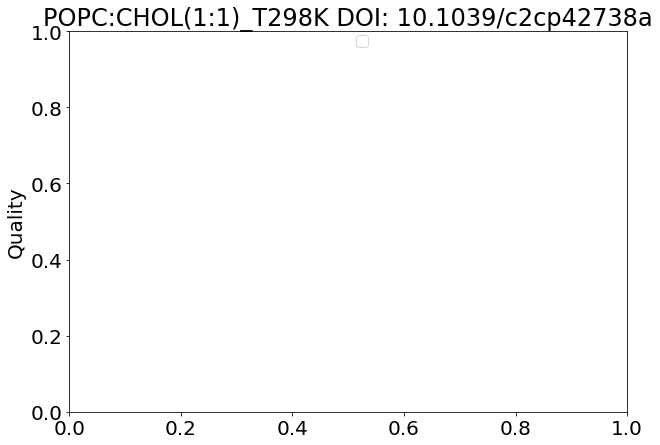

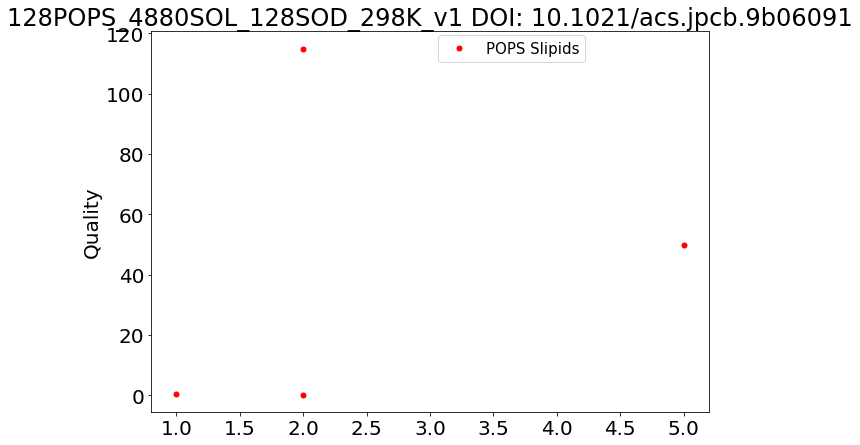

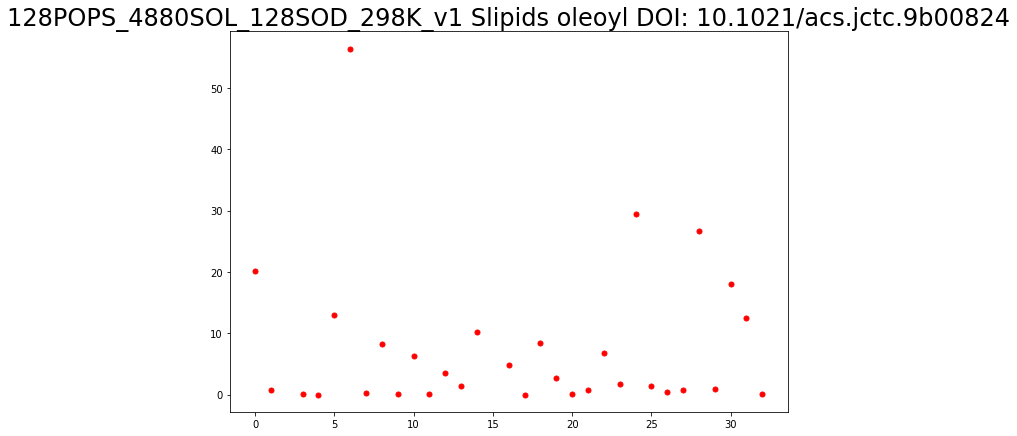

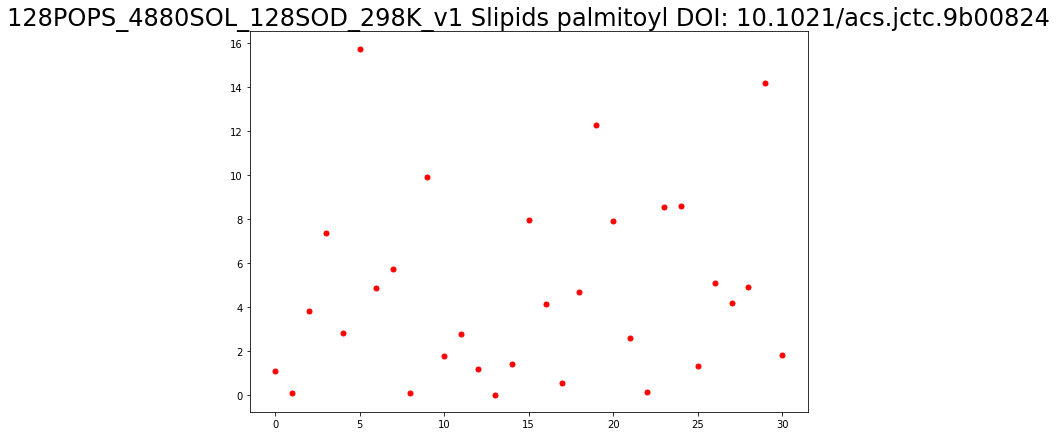

In [4]:
for system in systems:
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    for files in os.walk(path):
        #for file in files[2]:
        #    print(file)
        OPdata = {}
        for filename2 in files[2]:
            filepath2 = path + filename2
            if filepath2.endswith("_OrderParameters_quality.json"):
                lipid = filename2.replace('_OrderParameters_quality.json', '')
                #print(filepath2)
                with open(filepath2) as json_file:
                    OPdata[lipid] = json.load(json_file)
                json_file.close()
                #print(OPdata)
            
                #plot head group
                for key1 in OPdata.keys():
                    #print(key1)
                    data = OPdata[key1]
                    doi = readme['DOI']
                    #print(data)
                    plotHeadGroup(readme, data, key1) 
                    # plot oleoyl
                    name_tail = ["oleoyl","palmitoyl"]
                    plotTails(readme,data, name_tail[0])
                # plot palmitoyl
                    plotTails(readme,data, name_tail[1])
            

# Making a list of qualities

In [3]:
qualities = []
for system in systems:
    quality_dict = {}
    path = system['path']
    READMEfilepath = path + '/README.yaml'
    
    with open(READMEfilepath) as yaml_file:
        readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
    yaml_file.close()
    
    TotalQualityFilePath = path + '/SYSTEM_quality.json'
    
    
    
    FragmentQ = {}
    for lipid in readme['COMPOSITION']:
        QualityFile = path + lipid + '_FragmentQuality.json'
        #print(QualityFile)
        try:
            with open(QualityFile) as json_file:
                FragmentQ[lipid] = json.load(json_file)
            json_file.close()
        except:
            continue
        #print(lipid, FragmentQ[lipid])
    
    if (os.path.isfile(TotalQualityFilePath)):
        with open(TotalQualityFilePath) as json_file:
            FragmentQ['TotalQuality'] = json.load(json_file)
        json_file.close()
        #print(FragmentQ['TotalQuality'], '\n')
    
    FragmentQ['system'] = system
    qualities.append(FragmentQ)

# Ranking based on total quality

In [4]:
for i in qualities:
    Nlipid = {}
    try:
        totalQ = i['TotalQuality']['headgroup']
    except:
        continue
        
    if totalQ > 0:
        for lipid in i['system']['COMPOSITION']:
            #print(sum(i['system']['COMPOSITION'][lipid]['COUNT']))
            try:
                Nlipid[lipid] = sum(i['system']['COMPOSITION'][lipid]['COUNT']) 
            except:
                continue
                #print(Nlipid)
        #print(i)
        print(i['system']['FF'])
        print(i['system']['path'])
        print(Nlipid)
        print(totalQ)
        print('\n')
    

Slipids
../../Data/Simulations/02b/984/02b98418d9965749ac943ecae9627cfdd1dfbdcd/7339faa76da6c93cfee03e59f399e2eed1628b53/
{'POPS': 128}
171.44264853135417


CHARMM36
../../Data/Simulations/0c2/1a9/0c21a9be136ea0eb9df9e5c6cdc19f723a0af245/9ac73b6a98acb54a7a67a5d690794ad7f1e4a1d1/
{'POPG': 150, 'POPC': 150}
4.915298641013105


CHARMM36
../../Data/Simulations/0d5/d1d/0d5d1dcb43e775faf4e53c4f9ff255a67481bd38/9b487701b24d3fad83991e311188b08d3d5ea768/
{'POPG': 118}
56.21901640577534


slipids
../../Data/Simulations/8cb/989/8cb989e1813b93d1144d731ffbbc04a5cfcfb6a6/2db4e1d512355edd21cedbc0d28a45659dd6faa9/
{'CHOL': 256, 'POPC': 256}
25.051457367552715


Slipids
../../Data/Simulations/b56/b24/b56b24dc9838e1bfc337c1cc2f2880a82d5f7330/09d478c46cc9c5fe4f3d50ce4ca26d28e59fd099/
{'POPG': 288}
117.49786389755772


CHARMM36
../../Data/Simulations/b7a/4c6/b7a4c62a0f6112eb07c99e3fe912bd5e55e1dca2/5e824ebda9f3c3341685c5aa5a3ff3ad7ead34f5/
{'POPE': 500}
6.147453131078534


CHARMM36
../../Data/Simulations/

# Sort based on total quality of a simulation

In [4]:
Fragments = ['total','sn-1','sn-2','headgroup']

for SortBasedOn in Fragments:
    #print(SortBasedOn)
    NewQualities = []
    for i in qualities:
        try:
            if i['TotalQuality'][SortBasedOn] >0:
                NewQualities.append(i)
            #totalQ = i['TotalQuality']['headgroup']
        except:
            continue

    
    SortedQualities = sorted(NewQualities, key = lambda i: i['TotalQuality'][SortBasedOn])
    print('Sorted based on ', SortBasedOn, ' quality')
    print(pd.json_normalize(SortedQualities))
    
    
    outputfile = '../../Data/Ranking/SYSTEM_' + SortBasedOn + '_Ranking.json'
    with open(outputfile, "w") as fp:
        json.dump(SortedQualities, fp)
    
    #for simulation in SortedQualities:
    #    for molecule in simulation['system']['COMPOSITION']:
    #        print(molecule, np.sum(simulation['system']['COMPOSITION'][molecule]['COUNT']))
    #    print(simulation['system']['FF'])
    #    print(SortBasedOn,' quality of simulation: ',  simulation['TotalQuality'][SortBasedOn])
    #    print(simulation['system']['path'])
    #    print('\n')

Sorted based on  total  quality
   POPC.headgroup  POPC.sn-1  POPC.sn-2  POPC.total  TotalQuality.headgroup  \
0       51.908646   0.535656   1.682661   18.042321               51.908646   
1             NaN        NaN        NaN         NaN                5.690801   
2       68.509014  20.528095  13.624177   34.220429               68.509014   
3       71.930610  19.308345  17.561283   36.266746               71.930610   
4             NaN        NaN        NaN         NaN              170.675169   
5             NaN        NaN        NaN         NaN              171.442649   
6             NaN        NaN        NaN         NaN                4.283150   
7       50.102915  16.643377  16.324704   27.690332               25.051457   

   TotalQuality.sn-1  TotalQuality.sn-2  TotalQuality.total system.FF_DATE  \
0           0.535656           1.682661           18.042321             ??   
1          39.470786          34.284259           26.481948             ??   
2          20.528095  

# Sorting best simulations for each lipid

In [11]:
Fragments = ['total','sn-1','sn-2','headgroup']
#SortBasedOn = 'headgroup'

for SortBasedOn in Fragments:
    for lipid in lipids_dict:
        NewQualities = []
        for i in qualities:
            try:
                if i[lipid][SortBasedOn] >0:
                    NewQualities.append(i)
                #totalQ = i['TotalQuality']['headgroup']
            except:
                continue

    
        SortedQualities = sorted(NewQualities, key = lambda i: i[lipid][SortBasedOn])
    
        if SortedQualities:
            outputfile = '../../Data/Ranking/' + lipid + '_' + SortBasedOn + '_Ranking.json'
            with open(outputfile, "w") as fp:
                json.dump(SortedQualities, fp)

    
        for simulation in SortedQualities:
            for molecule in simulation['system']['COMPOSITION']:
                print(molecule, np.sum(simulation['system']['COMPOSITION'][molecule]['COUNT']))
            print(simulation['system']['FF'])
            print('Quality of',SortBasedOn,' of ',lipid,'in simulation: ',  simulation[lipid][SortBasedOn])
            print(simulation['system']['path'])
            print('\n')

In [23]:
QualityTable = []
for i in SortedQualities:
    StoredToTable = i['TotalQuality']
    StoredToTable['Forcefield'] = i['system']['FF']
    StoredToTable['Composition'] = ''
    for lipid in i['system']['COMPOSITION']:
        #print(np.sum(i['system']['COMPOSITION'][lipid]['COUNT']))
        StoredToTable['Composition'] = StoredToTable['Composition'] + lipid + ':' + str(np.sum(i['system']['COMPOSITION'][lipid]['COUNT'])) + ' '
    QualityTable.append(StoredToTable)

In [24]:
pd.json_normalize(QualityTable)

,headgroup,sn-1,sn-2,total,Forcefield,Composition
0,4.283150,119.422468,85.873231,69.859616,CHARMM36,POPS:128 SOL:4480 SOD:128
1,4.533664,0.000000,0.000000,0.000000,Slipids,POPG:128 POPC:128 SOL:12800 SOD:128
2,4.915299,0.000000,0.000000,0.000000,CHARMM36,POPG:150 POPC:150 SOL:31500 SOD:150
3,5.689747,0.000000,0.000000,0.000000,CHARMM36,SOL:5760 POPE:144
4,5.690801,39.470786,34.284259,26.481948,CHARMM36,POPS:128 SOL:4480 SOD:128
5,6.147453,0.000000,0.000000,0.000000,CHARMM36,SOL:25000 POPE:500
6,7.101838,0.000000,0.000000,0.000000,CHARMM36,POPG:88 POPC:350 SOL:26280 SOD:88
7,18.562978,0.000000,0.000000,0.000000,lipid17ecc,POPG:150 POPC:150 SOL:29865 SOD:150
8,25.051457,8.321688,8.162352,117.475004,slipids,CHOL:256 POPC:256 SOL:20334
9,51.908646,0.535656,1.682661,18.042321,Slipids,POPC:512 SOL:23943


In [13]:
StoredToTable
#QualityTable

{'headgroup': 239.72602739726028, 'sn-1': 0, 'sn-2': 0, 'total': 0}

In [22]:
print(tst)

    POPS.headgroup   POPS.sn-1  POPS.sn-2  POPS.total  TotalQuality.headgroup  \
0         4.283150  119.422468  85.873231   69.859616                4.283150   
1              NaN         NaN        NaN         NaN                4.533664   
2              NaN         NaN        NaN         NaN                4.915299   
3              NaN         NaN        NaN         NaN                5.689747   
4         5.690801   39.470786  34.284259   26.481948                5.690801   
5              NaN         NaN        NaN         NaN                6.147453   
6              NaN         NaN        NaN         NaN                7.101838   
7              NaN         NaN        NaN         NaN               18.562978   
8              NaN         NaN        NaN         NaN               25.051457   
9              NaN         NaN        NaN         NaN               51.908646   
10             NaN         NaN        NaN         NaN               56.219016   
11             NaN         N

""
